In [83]:
import networkx as nx
from Bio import Phylo
import pylab as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools as it
from collections import defaultdict

In [152]:
genome="A"

In [3]:
trees = Phylo.parse("RAxML_bestTree.ASC_GTRGAMMA_felsenstein.{genome}.1000.boot".format(genome=genome),"newick")
trees= [x for x in trees]

In [4]:
nodes=[x.name for x in trees[0].get_terminals()]

In [5]:
def process_tree(tree,nodes):
    G = nx.MultiGraph()
    for (u,v) in it.combinations(nodes,2):
        G.add_edge(u,v,weight=tree.distance(u,v))
    return(nx.minimum_spanning_tree(G,weight="weight"))

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

num_cores = 20
     
mst_trees = Parallel(n_jobs=num_cores)(delayed(process_tree)(i,nodes) for i in trees)


In [44]:
s=pd.read_excel("../Whealbi_500samples_table.xlsx",index_col=0)
s.head()

,Taxonomy,Taxonomy1,Taxonomy2,Genome,Variety/Genotype,Acession number,Other number,Replication,Plant,No.,...,any other important information.2,Glume Colour,Glume surface,Awn Colour,Grain Colour,Wax,Awn Type,SMTA related info,group,continent
Whealbi serial number,,,,,,,,,,,,,,,,,,,,,
WW-246,Aegilops,tauschii Coss.,subsp. Tauschii,D,NaN,IG 46803,NaN,NaN,2,NaN,...,SSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,diploide,Asia
WW-247,Aegilops,tauschii Coss.,subsp. tauschii,D,NaN,IG 48508,NaN,NaN,1,NaN,...,SSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,diploide,Africa
WW-248,Aegilops,tauschii Coss.,subsp. strangulata (Eig) Tzvel.,D,NaN,AE 525,NaN,NaN,2,NaN,...,SSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,diploide,Asia
WW-249,Triticum,urartu Thum. ex Gandil.,NaN,Au,NaN,ID 388 EP047-1,NaN,NaN,2,NaN,...,SSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,diploide,Asia
WW-250,Triticum,urartu Thum. ex Gandil.,NaN,Au,NaN,ID 393 EP048-1,NaN,NaN,3,NaN,...,SSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,diploide,Asia


In [45]:
s["Genome"]=pd.Categorical(s.Genome.str.replace("\s+","",regex=True))

In [143]:
G = nx.Graph()
for H in mst_trees:
    for (u,v) in H.edges():
        if G.has_edge(u,v):
            G[u][v]["weight"]+=1
        else:
            G.add_edge(u,v,weight=1)

In [144]:
for (u,v,w) in G.edges(data="weight"):
    G[u][v]["weight"]=1-(w / len(mst_trees))
    G[u][v]["weight2"]=(w / len(mst_trees))

In [145]:
GM=nx.minimum_spanning_tree(G)

In [148]:
nn=defaultdict(list)
col=dict()
for n in G.nodes():
    nn[s.Genome.loc[n]].append(n)
    col[s.Genome.loc[n]]=plt.cm.get_cmap('Paired')(s.Genome.cat.codes.loc[n])

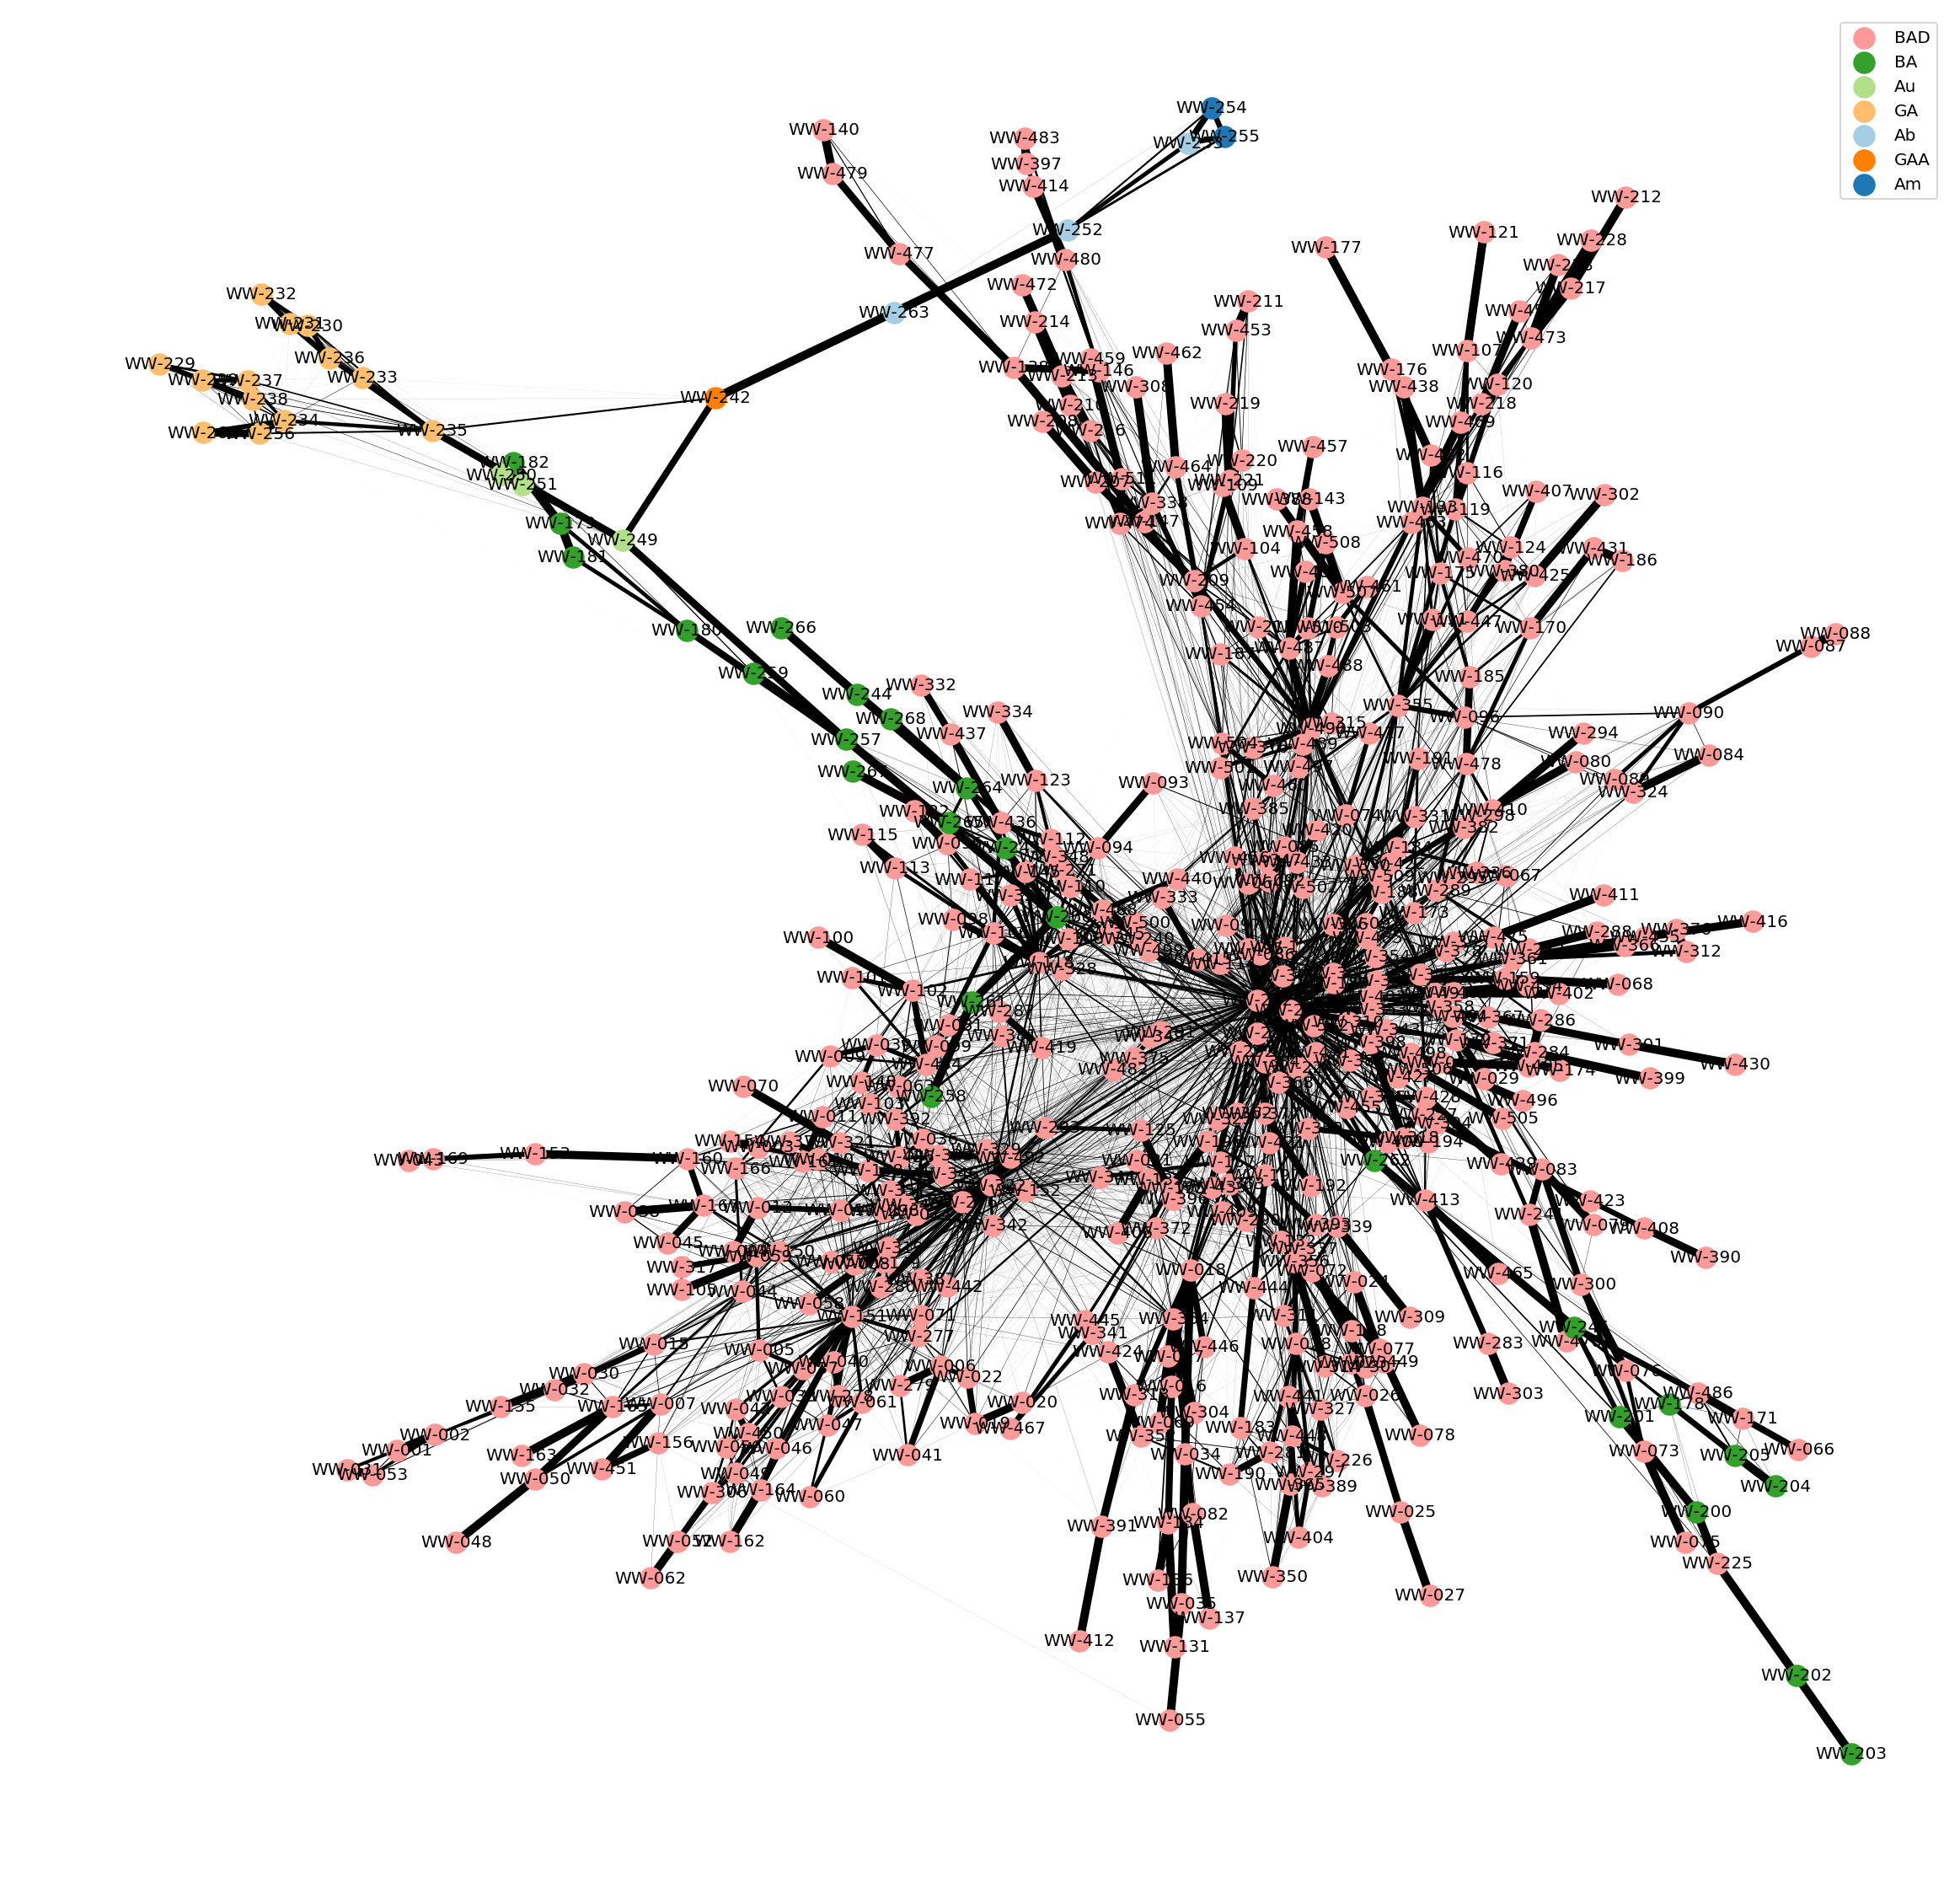

In [149]:
pos=nx.spring_layout(G,weight="weight2")
edgewidth = [ (d['weight2'])*5 for (u,v,d) in G.edges(data=True)]
#nx.draw(GM,cmap=plt.cm.Paired,ax=None)
for genome in nn.keys():
    nx.draw_networkx_nodes(G,pos=pos,nodelist=nn[genome],node_color=col[genome],
                           label=genome,cmap=plt.cm.Paired,node_size=150)

nx.draw_networkx_edges(G, pos, width=edgewidth,)
nx.draw_networkx_labels(G,pos,font_size=10)
plt.rcParams['figure.figsize'] = (20, 20)
%config InlineBackend.figure_format='retina'
plt.legend(loc='best')
plt.axis('off')
pl.show()

In [135]:
nn=defaultdict(list)
col=dict()
for n in GM.nodes():
    nn[s.Genome.loc[n]].append(n)
    col[s.Genome.loc[n]]=plt.cm.get_cmap('Paired')(s.Genome.cat.codes.loc[n])

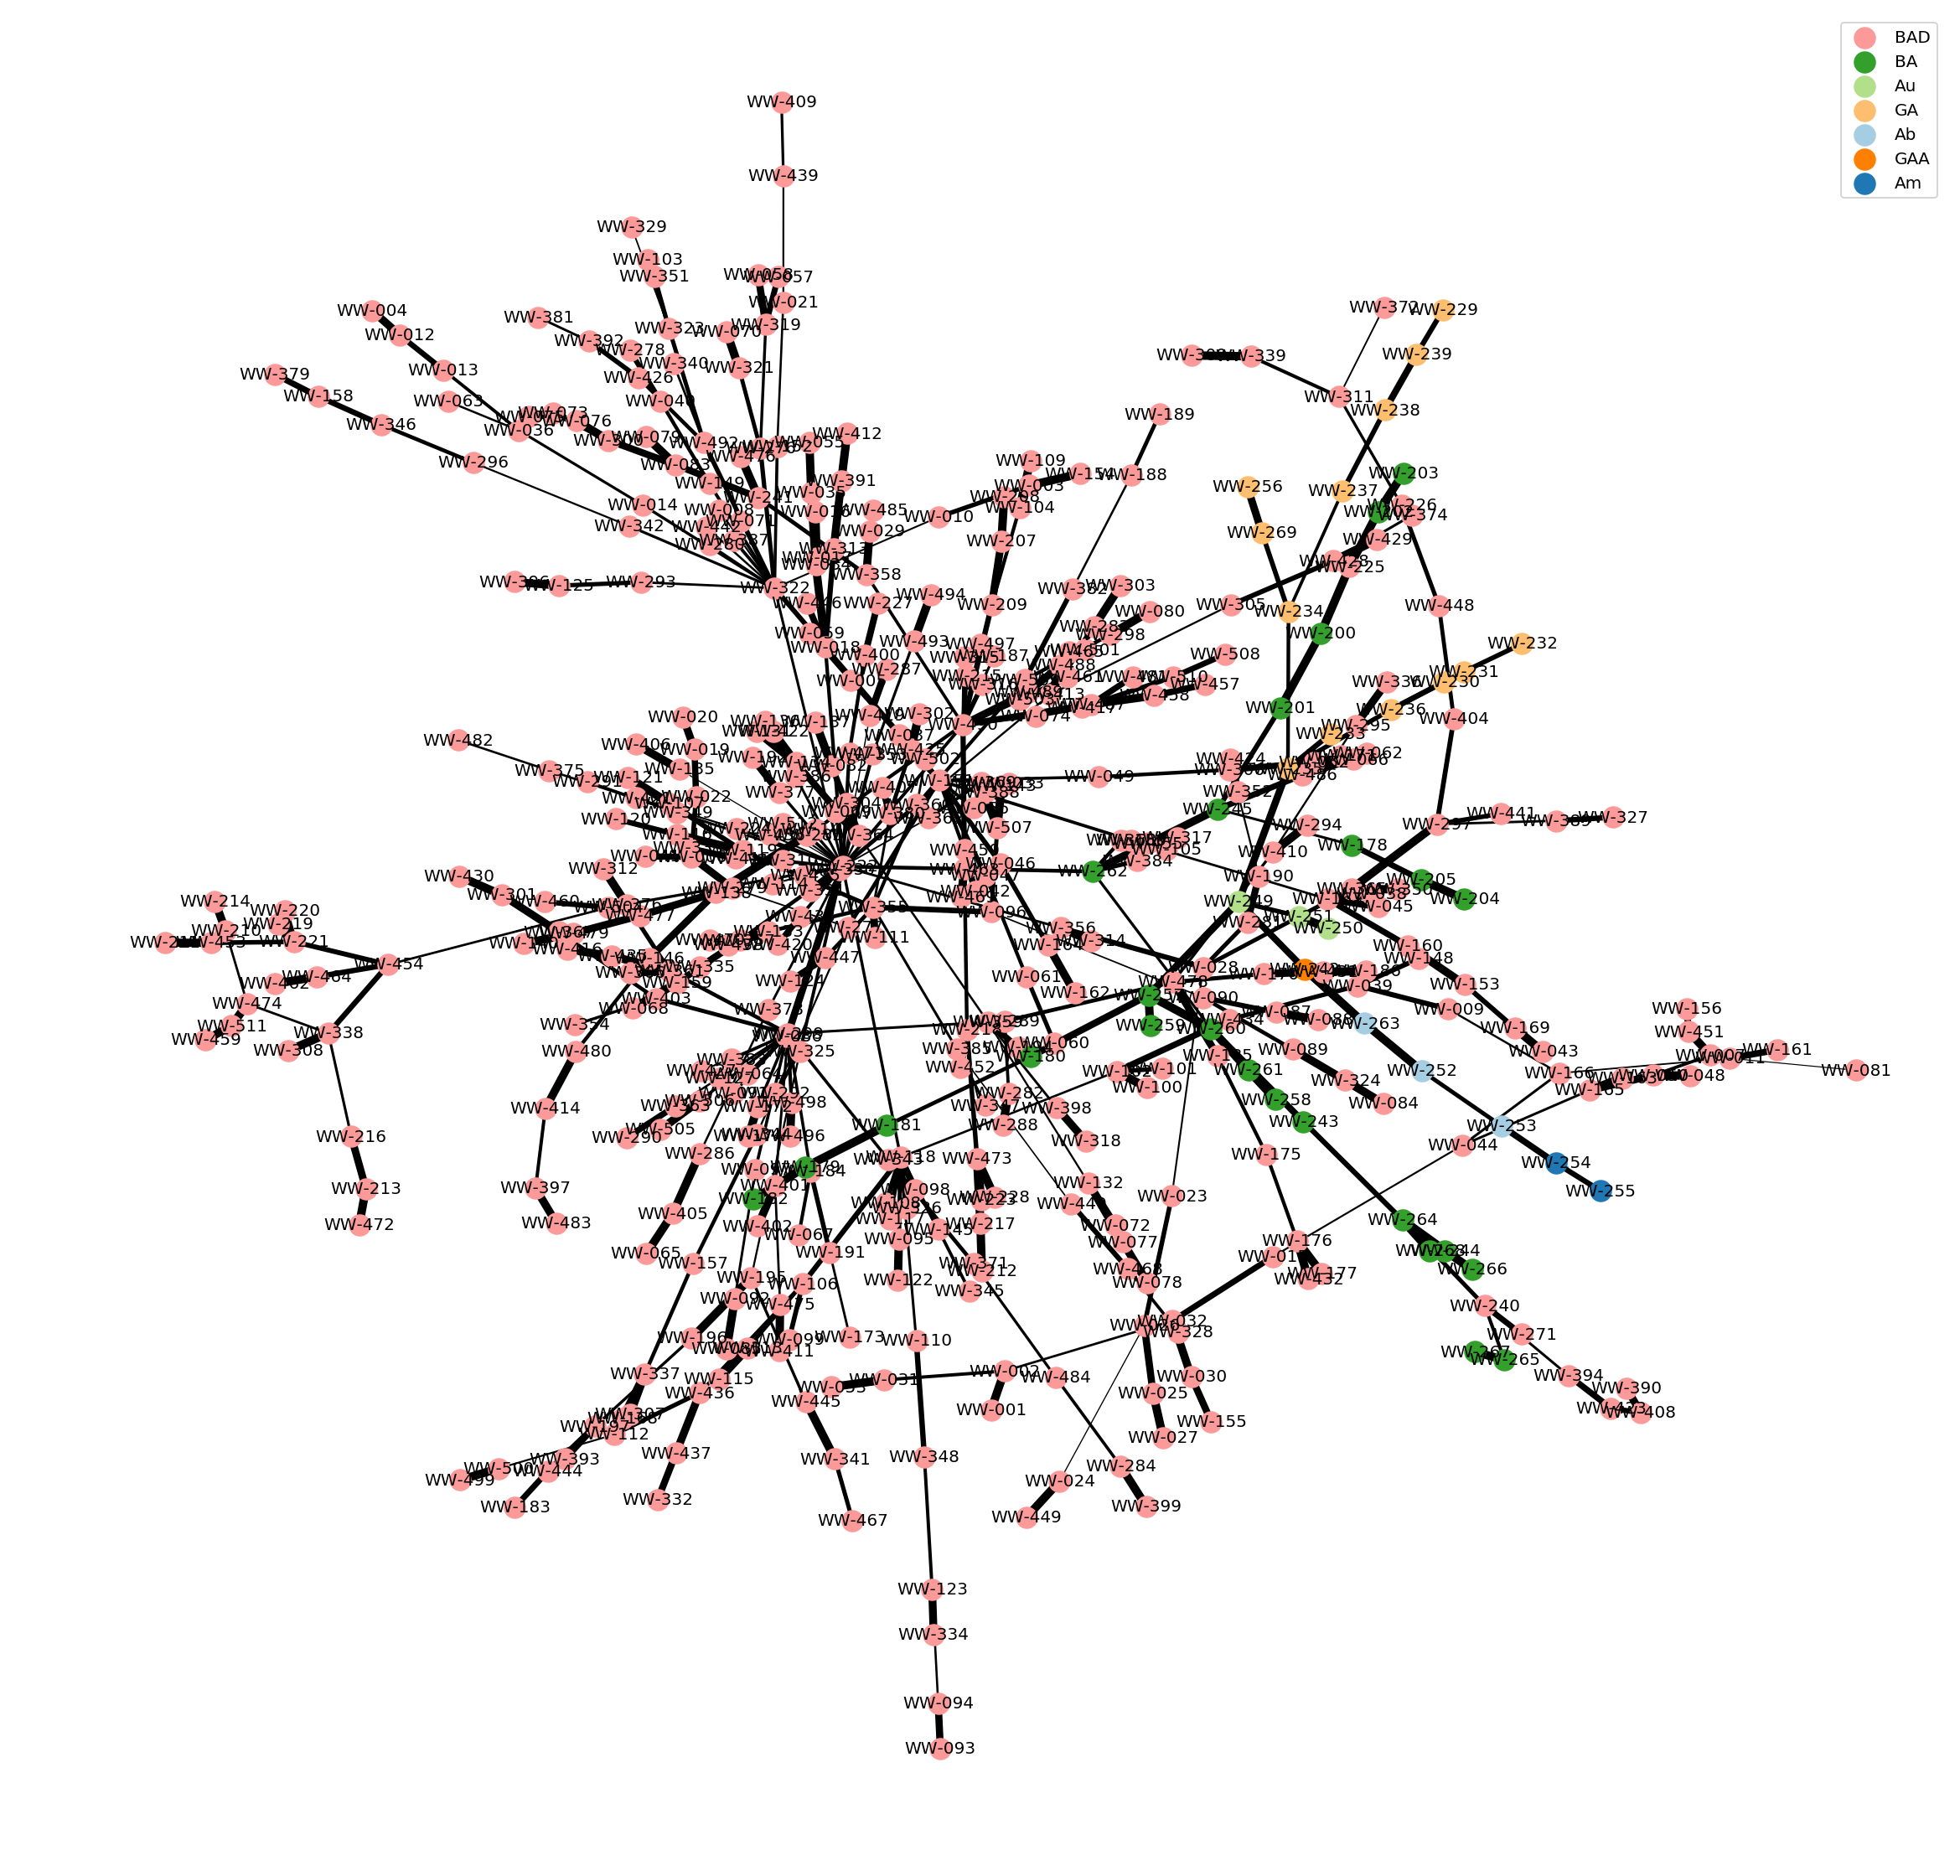

In [140]:
pos=nx.spring_layout(GM,weight="weight2")
edgewidth = [ (d['weight2'])*5 for (u,v,d) in GM.edges(data=True)]
#nx.draw(GM,cmap=plt.cm.Paired,ax=None)
for genome in nn.keys():
    nx.draw_networkx_nodes(GM,pos=pos,nodelist=nn[genome],node_color=col[genome],
                           label=genome,cmap=plt.cm.Paired,node_size=150)

nx.draw_networkx_edges(GM, pos, width=edgewidth,)
nx.draw_networkx_labels(GM,pos,font_size=10)
plt.rcParams['figure.figsize'] = (20, 20)
%config InlineBackend.figure_format='retina'
plt.legend(loc='best')
plt.axis('off')
pl.show()

In [153]:
nx.write_edgelist(G,"Consensus_network.1000_RAxML.{genome}.tsv".format(genome=genome),data=["weight2"])

In [154]:
nx.write_edgelist(GM,"Consensus_network.1000_RAxML2MST.{genome}.tsv".format(genome=genome),data=["weight2"])